In [43]:
import GWPhotonCounting
import jax.numpy as jnp
import jax
import numpy as np
import bilby
from bilby_cython.geometry import frequency_dependent_detector_tensor

import json
import sys
import os

from scipy.optimize import minimize

from astropy.cosmology import Planck18
import astropy.units as u

# injected snr
idx = 0

from tqdm import tqdm

import jax

import os
jax.config.update("jax_enable_x64", True)

frequencies = jnp.sort(jnp.fft.fftfreq(2**12, d=1/1e4))

# TODO make this work on non-linear frequencies array
dF = frequencies[1] - frequencies[0]
duration = 1/dF
print("DURATION: ", duration)

#frequencies = jnp.sort(jnp.fft.fftfreq(2**12, d=1/1e4))
print("freq max", np.max(frequencies))
print("dF", frequencies[-1] - frequencies[-2])

# Setting up the two detectors to compare the
detector_nosqz = GWPhotonCounting.detector.Detector(
    frequencies, '/home/mcculler/projects/GWPhotonCounting/examples/data/CE_shot_psd_nosqz.csv',
    '/home/mcculler/projects/GWPhotonCounting/examples/data/CE_classical_psd.csv',
    gamma=80, random_seed=1632, N_frequency_spaces=17*2, N_time_spaces=4)

detector_sqz = GWPhotonCounting.detector.Detector(
    frequencies, '/home/mcculler/projects/GWPhotonCounting/examples/data/CE_total_psd_sqz.csv', None,
    gamma=80, random_seed=1632, N_frequency_spaces=17*2, N_time_spaces=4)


#Loading in the individual analysis from the sample
KNNModel = GWPhotonCounting.signal.PostMergerKNN(knn_file_path='/home/mcculler/photon_counting/apr4_knn_gw_model_2024/KNN_Models/APR4-knn_model-N100')
LorentzianModel = GWPhotonCounting.signal.PostMergerLorentzian()
dataset = np.genfromtxt(f'/home/mcculler/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_MLE_260213.dat') #bns_pm_dataset_MLE_250609
#dataset = np.genfromtxt(f'/home/mcculler/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_MLE_250609.dat') #bns_pm_dataset_MLE_250609

# OK, now sorting on SNR for the first 10000!!!
if idx <= 10000:
    mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, snr, snr_sqz = dataset[:10000].T
    #print(dataset.shape)
    #print(snr.shape)
    snr_idx = np.argsort(-snr)
    #print(snr_idx.shape)
    sorted_dataset = dataset[snr_idx]
    #print(sorted_dataset.shape)
    mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, snr, snr_sqz = sorted_dataset[idx]
else:
    mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, snr, snr_sqz = dataset[idx]

amplitude_samples = dataset[:, 9] #* Planck18.luminosity_distance( dataset[:,1]).value /Planck18.luminosity_distance(z).value
gamma_samples = dataset[:, 8]

# Compute the expected number of photons and the strain
PM_strain = KNNModel.generate_strain(detector_nosqz, frequencies, mtots, phi, z, ra, dec, iota, psi)

snr = detector_nosqz.calculate_optimal_snr(PM_strain, frequencies)
snr_sqz = detector_sqz.calculate_optimal_snr(PM_strain, frequencies)
print('SNRs are: ', snr, snr_sqz)
print('f0_fit: ', f0_fit)

# # What I'm doing here is generating a Lorentzian signal with the same amplitude as the KNN model
# # I'm using this as a replacemenet/test because then the amplitude of the signal that we recover with and inject with is the same!
# PM_strain = LorentzianModel.generate_strain(
#     detector_nosqz, frequencies, f0=f0_fit, gamma=gamma_fit, A=A_fit, phase=0, t0=0)[0]

# if detector_nosqz.calculate_optimal_snr(PM_strain, frequencies) > snr:
#     A = A_fit* snr / detector_nosqz.calculate_optimal_snr(PM_strain, frequencies)

#     PM_strain = LorentzianModel.generate_strain(
#         detector_nosqz, frequencies, f0=f0_fit, gamma=gamma_fit, A=A, phase=0, t0=0)[0]


# print(A_fit, detector_nosqz.calculate_optimal_snr(PM_strain, frequencies), snr)

# Getting the frequencies
R1d6s = np.linspace(10,14,100) # 25
f0_R1d6s = GWPhotonCounting.hierarchical.frequency_model(mtots, R1d6s)/(1+z)

# Setting up the likelihood
poisson_likelihood = GWPhotonCounting.distributions.PoissonPhotonLikelihood()
noise_likelihood = GWPhotonCounting.distributions.PhaseQuadraturePhotonLikelihood()
gaussian_likelihood = GWPhotonCounting.distributions.GaussianStrainLikelihood()
convolved_likelihood = GWPhotonCounting.distributions.MixturePhotonLikelihood(poisson_likelihood, noise_likelihood)

# Marginalizing over the likelihood
N_samples = 200
N_t0s = 10

np.random.seed()
n_exp = np.sum(detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies))
n_self = detector_nosqz.calculate_signal_photon_expectation_self(PM_strain, frequencies)
print('Expected number of photons (vs HD), (into templates), (full power): ', snr**2/4, n_exp, n_self)
# Calculation for the CE1 detector
observed_photons, signal_photons, noise_photons = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies),
        detector_nosqz.noise_photon_expectation)
_, _, noise_photons_0d01 = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies),
        0.01 * detector_nosqz.noise_photon_expectation)
_, _, noise_photons_0d1 = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies),
        0.1 * detector_nosqz.noise_photon_expectation)
_, _, noise_photons_0d5 = convolved_likelihood.generate_realization(
        detector_nosqz.calculate_signal_photon_expectation(PM_strain, frequencies),
        0.5 * detector_nosqz.noise_photon_expectation)
observed_photons_no_background = signal_photons

likelihood_event_i = np.zeros(len(f0_R1d6s))
likelihood_event_i_0d01 = np.zeros(len(f0_R1d6s))
likelihood_event_i_0d1 = np.zeros(len(f0_R1d6s))
likelihood_event_i_0d5 = np.zeros(len(f0_R1d6s))
likelihood_event_i_no_background = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain_15db = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain_20db = np.zeros(len(f0_R1d6s))
likelihood_event_i_strainMx = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain_15dbMx = np.zeros(len(f0_R1d6s))
likelihood_event_i_strain_20dbMx = np.zeros(len(f0_R1d6s))

t0s = jnp.linspace(-0.02, 0.02, N_t0s)

# Attempt at fixing the calculation in the hierarchical analysis.....
def neg_logl_cost_function(x0, strain, frequencies, noise_psd):

    f0, gamma, log10A, phase, t0 = x0

    t0s = np.array([t0])

    # Calculate the expected strain
    lorentzian_strain = LorentzianModel.generate_strain(
        detector_sqz, frequencies, f0=f0, gamma=gamma, A=10**log10A, phase=phase, t0=t0s)

    # Calculate the log-likelihood
    logl = gaussian_likelihood(strain, lorentzian_strain, noise_psd,frequencies)

    # Return the negative logl
    return -logl

def neg_logl_cost_function_split(x0, strain, frequencies):

    f0, gamma, log10A, phase = x0

    t0s = jnp.linspace(-0.02, 0.02, 100)

    # Calculate the expected strain
    lorentzian_strain = LorentzianModel.generate_strain(
        detector_nosqz, frequencies, f0=f0, gamma=gamma, A=10**log10A, phase=phase, t0=t0s)

    # Return the negative logl
    t0s, logl = np.array([
		[t0s[i], gaussian_likelihood(strain, lorentzian_strain[i].reshape(1, -1), jnp.ones(len(frequencies))*1e-55,frequencies)]
		for i in range(len(t0s))
	]).T
    midx = np.argmin(-logl)
    return t0s[midx], logl[midx]


result_fits = []
neg_logls = []
for i in tqdm(range(100)):
    params_0 = [np.abs(np.random.uniform(.99,1.01) * frequencies[np.argmax(np.abs(PM_strain))]), np.random.uniform(1,100), np.random.uniform(-10,1), np.random.uniform(0,2*np.pi), 0.02]
    minimize_result = minimize(neg_logl_cost_function,
                                x0=params_0,
                                args=(PM_strain/np.max(np.abs(PM_strain)), frequencies, np.ones_like(frequencies)),
                                bounds=((500, 5000), (0, 200), (-5, 5), (0, 2*np.pi), (-.05, .1)))

    result_fits.append(minimize_result.x)
    neg_logls.append(minimize_result.fun)

fpeak_fit, gamma_fit, log10A_fit_pc, phase_fit, t0_fit = result_fits[np.argmin(neg_logls)]
print('fpeak_fit: ', fpeak_fit)
print('amp_fit: ', 10**log10A_fit_pc)
#which = neg_logl_cost_function_split((fpeak_fit, gamma_fit, log10A_fit_pc, phase_fit), PM_strain, frequencies)
#t0_fit, logl = which
print("T0:", t0_fit)

neg_logl_pc = np.min(neg_logls)
fitted_signal = LorentzianModel.generate_strain(
        detector_sqz, frequencies, f0=fpeak_fit, gamma=gamma_fit, A=10**log10A_fit_pc * np.max(np.abs(PM_strain)), phase=phase_fit, t0=t0_fit)[0]

snr_fit_pc = detector_nosqz.calculate_optimal_snr(fitted_signal, frequencies)
snr_cross = detector_nosqz.calculate_inner_product(PM_strain, fitted_signal, frequencies)
SNR_frac = (snr_cross**2 / snr_fit_pc / snr)
print("SNR, SNR_L, SNR_X, fraction_overlap: ", snr, snr_fit_pc, snr_cross, SNR_frac)

# result_fits = []
# neg_logls = []
# #params_0 = [np.abs(frequencies[np.argmax(np.abs(PM_strain))]), np.random.uniform(0,200), jnp.log10(np.max(np.abs(PM_strain))), np.random.uniform(0,2*np.pi)]
# for i in tqdm(range(100)):
#     params_0 = [np.random.uniform(500,5000), np.random.uniform(0,200), np.log10(A_fit), np.random.uniform(0,2*np.pi)]
#     minimize_result = minimize(neg_logl_cost_function,
#                                 x0=params_0,
#                                 args=(PM_strain, frequencies, detector_sqz.total_psd),
#                                 bounds=((500, 5000), (0, 200), (-40, -21), (0, 2*np.pi)))
#     _, _, log10A_fit, _ = minimize_result.x

#     result_fits.append(minimize_result.x)
#     neg_logls.append(minimize_result.fun)

# fpeak_fit, gamma_fit, log10A_fit_strain, phase_fit = result_fits[np.argmin(neg_logls)]
# neg_logl_strain = np.min(neg_logls)
# fitted_signal = LorentzianModel.generate_strain(
#         detector_sqz, frequencies, f0=fpeak_fit, gamma=gamma_fit, A=10**log10A_fit_strain, phase=phase_fit, t0=0)[0]
# snr_fit_strain = detector_sqz.calculate_optimal_snr(fitted_signal, frequencies)

# log10A_fits = []
# neg_logls = []
# for i in tqdm(range(100)):
#     params_0 = [np.random.uniform(500,5000), np.random.uniform(0,200), np.log10(A_fit), np.random.uniform(0,2*np.pi)]
#     minimize_result = minimize(neg_logl_cost_function,
#                                 x0=params_0,
#                                 args=(PM_strain, frequencies, 10**(-0.5) * detector_sqz.total_psd),
#                                 bounds=((500, 5000), (0, 200), (-40, -21), (0, 2*np.pi)))
#     _, _, log10A_fit, _ = minimize_result.x

#     result_fits.append(minimize_result.x)
# #     neg_logls.append(minimize_result.fun)

# fpeak_fit, gamma_fit, log10A_fit_strain_15db, phase_fit = result_fits[np.argmin(neg_logls)]
# neg_logl_strain_15db = np.min(neg_logls)
# fitted_signal = LorentzianModel.generate_strain(
#         detector_sqz, frequencies, f0=fpeak_fit, gamma=gamma_fit, A=10**log10A_fit_strain_15db, phase=phase_fit, t0=0)[0]
# snr_fit_strain_15db = detector_sqz.calculate_optimal_snr(fitted_signal, frequencies) *(10**(-0.5))

print('Log10A fit is: ', A_fit, 10**log10A_fit_pc * np.max(np.abs(PM_strain)), log10A_fit_pc)#, log10A_fit_strain, log10A_fit_strain_15db)
print('SNRs are (PM, SQZ, FIT, CROSS, FRAC): ', snr, snr_sqz, snr_fit_pc, snr_cross, SNR_frac)#, snr_fit_strain, snr_fit_strain_15db)
print('neg_logls are: ', neg_logl_pc)#, neg_logl_strain * np.sum(detector_sqz.total_psd/detector_nosqz.total_psd), neg_logl_strain_15db * np.sum(detector_sqz.total_psd*10**(-0.5)/detector_nosqz.total_psd))
print('Photon counts are: ', np.sum(signal_photons), np.sum(noise_photons), np.sum(noise_photons_0d1))

DURATION:  0.4096
freq max 4997.55859375
dF 2.44140625
N_total_filters for Nyquist: 272
N_total_filters from user: 272
FSHAPE (272, 4096)
eff 1.0
eff15 0.9488757904684294
N_total_filters for Nyquist: 272
N_total_filters from user: 272
FSHAPE (272, 4096)
eff 1.0
eff15 0.9477453860364459
SNRs are:  0.674550421606482 1.8169196291765664
f0_fit:  2979.5593255502185
Expected number of photons (vs HD), (into templates), (full power):  0.11375456782237067 0.03570269189019343 (np.float64(0.11392885027604129), np.float64(0.11374399063935323))


100%|██████████| 100/100 [00:36<00:00,  2.74it/s]

fpeak_fit:  2951.4503458737377
amp_fit:  0.8240456076355251
T0: 0.022446587763867473
SNR, SNR_L, SNR_X, fraction_overlap:  0.674550421606482 0.5255340962944944 0.5239111724703891 0.7742834986617516
Log10A fit is:  2.797192784403152e-26 2.1092496519001754e-26 -0.08404875117144255
SNRs are (PM, SQZ, FIT, CROSS, FRAC):  0.674550421606482 1.8169196291765664 0.5255340962944944 0.5239111724703891 0.7742834986617516
neg_logls are:  -1935.5762548246214
Photon counts are:  0 0.0 0.0


/tmp/ipykernel_280371/1180462139.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


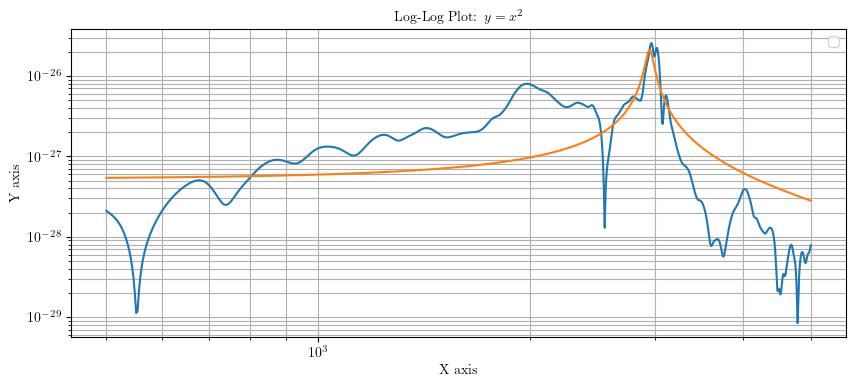

In [44]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4)) #
fsel = frequencies > 500

ax1.loglog(frequencies[fsel], abs(PM_strain[fsel]))
ax1.loglog(frequencies[fsel], abs(fitted_signal[fsel]))
ax1.set_title('Log-Log Plot: $y=x^2$')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.grid(True, which="both", ls="-") # Show grid for both major and minor ticks
ax1.legend()

/tmp/ipykernel_280371/4106249755.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


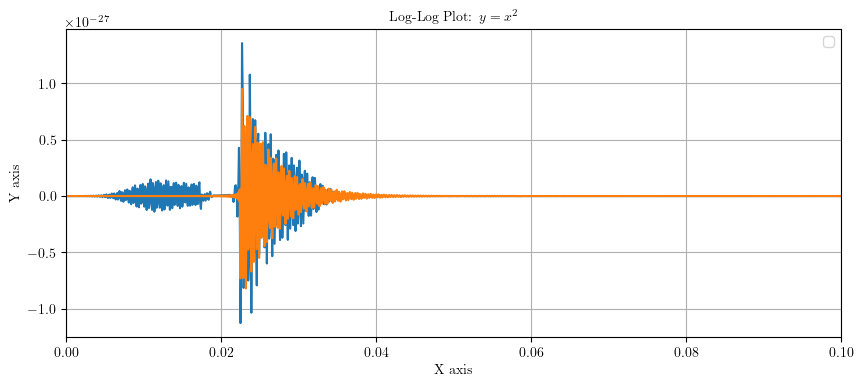

In [45]:
T = np.arange(len(frequencies)) / (2 * np.max(frequencies))
PM_strainT = np.fft.ifft(np.fft.ifftshift(PM_strain))
fitted_signalT = np.fft.ifft(np.fft.ifftshift(fitted_signal))
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4)) #

ax1.plot(T, PM_strainT.real)
ax1.plot(T, fitted_signalT.real)
#ax1.loglog(frequencies[fsel], abs(fitted_signal[fsel]))
ax1.set_title('Log-Log Plot: $y=x^2$')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.grid(True, which="both", ls="-") # Show grid for both major and minor ticks
ax1.set_xlim(0, 0.1)
ax1.legend()

In [42]:
frequencies

Array([-5000.        , -4998.77929688, -4997.55859375, ...,
        4996.33789062,  4997.55859375,  4998.77929688], dtype=float64)

In [32]:
jnp.fft.fftfreq(2**13, d=1/1e4)
jnp.fft.ifftshift?

Signature:
jnp.fft.ifftshift(
    x: 'ArrayLike',
    axes: 'None | int | Sequence[int]' = None,
) -> 'Array'
Docstring:
The inverse of :func:`jax.numpy.fft.fftshift`.

JAX implementation of :func:`numpy.fft.ifftshift`.

Args:
  x: N-dimensional array array of frequencies.
  axes: optional integer or sequence of integers specifying which axes to
    shift. If None (default), then shift all axes.

Returns:
  A shifted copy of ``x``.

See also:
  - :func:`jax.numpy.fft.fftshift`: inverse of ``ifftshift``.
  - :func:`jax.numpy.fft.fftfreq`: generate FFT frequencies.

Examples:
  Generate FFT frequencies with :func:`~jax.numpy.fft.fftfreq`:

  >>> freq = jnp.fft.fftfreq(5)
  >>> freq
  Array([ 0. ,  0.2,  0.4, -0.4, -0.2], dtype=float32)

  Use :func:`~jax.numpy.fft.fftshift` to shift the zero-frequency entry
  to the middle of the array:

  >>> shifted_freq = jnp.fft.fftshift(freq)
  >>> shifted_freq
  Array([-0.4, -0.2,  0. ,  0.2,  0.4], dtype=float32)

  Unshift with ``ifftshift`` to r

In [12]:
jnp.sort(jnp.fft.fftfreq(2**13, d=1/1e4)) == jnp.fft.fftshift(jnp.fft.fftfreq(2**13, d=1/1e4))

Array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)